In [1]:
import os
import sys
import json
from datasets import (load_dataset, 
    load_from_disk,
    Dataset,
    DatasetDict,
    Value,
    Features
)

In [2]:
import torch
import random
import pandas as pd
import numpy as np
import collections
import matplotlib.pyplot as plt

In [3]:
from transformers import AutoTokenizer

In [4]:
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from abc import *

In [5]:
def seed_everything(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

In [6]:
seed_everything(1227)

## Loading Data

In [7]:
class Loader(metaclass=ABCMeta) :
    def __init__(self, train_dir, val_dir) :
        self.train_dir = train_dir
        self.val_dir = val_dir

    def read_data(self) :
        train_data = []
        train_files = os.listdir(self.train_dir)
        for f in train_files :
            file_path = os.path.join(self.train_dir, f)
            files = self.read_json(file_path)
            data_list = self.parsing(files, f)
            train_data.extend(data_list)

        val_data = []
        val_files = os.listdir(self.val_dir)
        for f in val_files :
            file_path = os.path.join(self.val_dir, f)
            files = self.read_json(file_path)
            
            val_list = self.parsing(files, f)
            val_data.extend(val_list)
        
        total_data = train_data + val_data
        return total_data

    def read_json(self, file_path) :
        with open(file_path, 'r') as f :
            json_data = json.load(f)
        return json_data
        
    @abstractmethod
    def parsing(self, data, file_name) :
        pass

In [8]:
class PaperLoader(Loader) :

    def parsing(self, data, file_name) :
        total_data = []
        data = data['data']
        for element in data :
            data_dict = self.parsing_ele(element, file_name)
            total_data.append(data_dict)
        return total_data

    def parsing_ele(self, data, file_name) :
        doc_id = data['doc_id']
        title = data['title']
        entire = data['summary_entire'][0]
        document = entire['orginal_text']

        data_dict = {'doc_type' : '논문', 'file' : file_name, 'doc_id' : doc_id, 'text' : document, 'title' : title}
        return data_dict

In [9]:
train_dir = '/opt/ml/project/final/Data/paper/training_논문'
val_dir = '/opt/ml/project/final/Data/paper/validation_논문'

In [10]:
paper_loader = PaperLoader(train_dir, val_dir)
total_data = paper_loader.read_data()

In [11]:
valid_data = []
doc_set = set()

for data in total_data :
    if data['text'] in doc_set :
        continue

    doc_set.add(data['text'])
    valid_data.append(data)

In [12]:
train_data, val_data = train_test_split(valid_data, test_size=0.2, random_state=1227)

In [13]:
print('Size of Train Data : %d' %len(train_data))
print('Size of Validation Data : %d' %len(val_data))
print('Size of Total Data : %d' %(len(train_data)+len(val_data)))

Size of Train Data : 73640
Size of Validation Data : 18411
Size of Total Data : 92051


In [14]:
train_data[0]

{'doc_type': '논문',
 'file': '논문요약_0206_0.json',
 'doc_id': 'A201008192682',
 'text': '역시간 구조보정은 음원영역 파동장 외삽과 수진기영역 파동장 외삽의 상호상관으로 지층구조를 영상화하는 방법으로 복잡한 등방성 매질 층서구조를 영상화하는데 주로 이용된다. 그러나 일반적으로 지구내부 지층구조는 이방성 특성을 지니고 있으므로 이방성을 고려한 구조보정 기술이 필요하다. 여기에서는 편미분 파동장과 음원모음의 내적에 의한 알고리즘과 가상음원과 역전파 파동장과의 내적에 의한 알고리즘을 이용하여 횡적등방성 매질에서 역시간 구조보정 기술을 개발하고자 하였다. 단순 이방성 지층모델에 대한 수치모형실험 결과, 두 가지 방법에 의한 지층단면도 영상은 거의 차이가 없어 가상음원과 역전파 파동장과의 내적으로 구조보정을 실시하는 것이 효과적임을 알 수 있었다. 수평적으로 속도가 변하는 이방성 매질 지층구조에서 편미분 파동장을 구하지 않고 영상화 할 수 있음을 알 수 있었다.',
 'title': '횡적등방성 매질에서 중합전 역시간 구조보정'}

### Part 1 : Length

In [15]:
train_doc = [data['text'] for data in train_data]
train_title = [data['title'] for data in train_data]

In [16]:
doc_len = [len(doc) for doc in train_doc]
title_len = [len(doc) for doc in train_title]

In [17]:
print('Max Document Size : %d' %max(doc_len))

Max Document Size : 4672


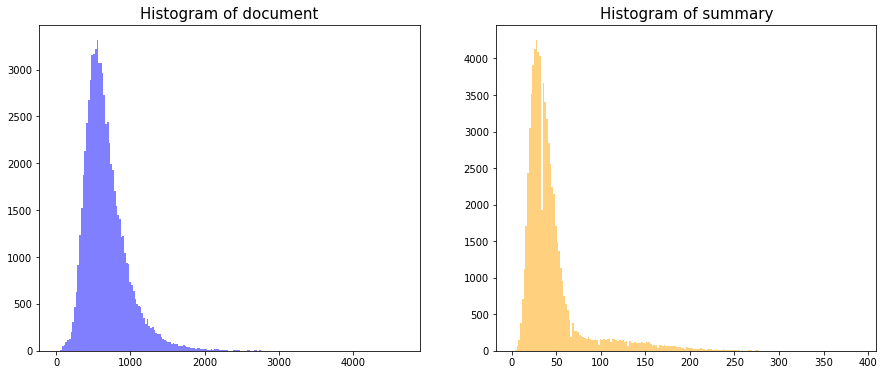

In [18]:
fig, axes = plt.subplots(1,2,figsize=(15,6))

axes[0].set_title('Histogram of document', fontsize=15)
axes[0].hist(doc_len, color='blue', bins=200, alpha=0.5)

axes[1].set_title('Histogram of summary', fontsize=15)
axes[1].hist(title_len, color='orange', bins=200, alpha=0.5)

plt.show()

### Long or Short Case

In [19]:
long_doc = [doc for doc in train_doc if len(doc) > 2000]
print('Size of Document which size is overt than 2000 : %d' %len(long_doc))

Size of Document which size is overt than 2000 : 268


In [20]:
short_title = [data['title'] for data in train_data if len(data['title']) <= 10]
print('Size of Title which size is 1 : %d' %len(short_title))

Size of Title which size is 1 : 377


## Tokenizer

In [22]:
tokenizer = AutoTokenizer.from_pretrained('klue/roberta-large')

In [23]:
train_doc_tokenized = [tokenizer.tokenize(doc) for doc in tqdm(train_doc)]
train_title_tokenized = [tokenizer.tokenize(doc) for doc in tqdm(train_title)]

  0%|          | 0/73640 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (681 > 512). Running this sequence through the model will result in indexing errors


  0%|          | 0/73640 [00:00<?, ?it/s]

In [24]:
tokenized_doc_len = [len(doc) for doc in train_doc_tokenized]
tokenized_title_len = [len(doc) for doc in train_title_tokenized]

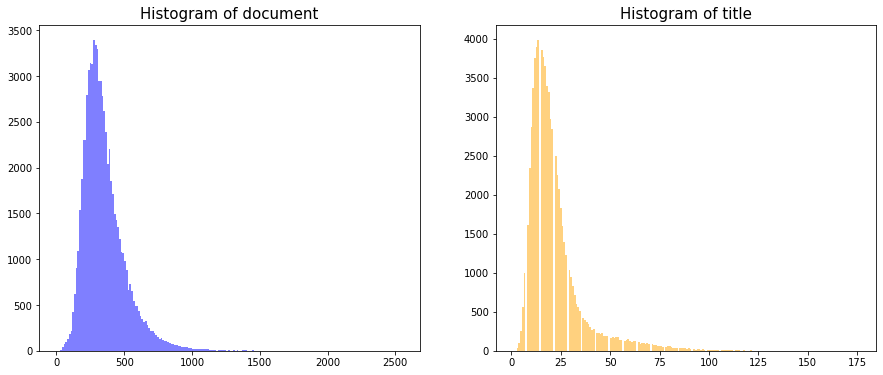

In [25]:
fig, axes = plt.subplots(1,2,figsize=(15,6))

axes[0].set_title('Histogram of document', fontsize=15)
axes[0].hist(tokenized_doc_len, color='blue', bins=200, alpha=0.5)

axes[1].set_title('Histogram of title', fontsize=15)
axes[1].hist(tokenized_title_len, color='orange', bins=200, alpha=0.5)
plt.show()

## Key Word in Document

In [41]:
from konlpy.tag import Mecab
mecab = Mecab()

In [42]:
def extract(title) :
    pos_tag_data = mecab.pos(title)
    token_list = [tok[0] for tok in pos_tag_data if tok[1].startswith('N')]
    return token_list

In [54]:
def flag_count(doc, tok_list) :
    text_flag = [1 if tok in doc['text'] else 0 for tok in tok_list]
    return text_flag

In [55]:
def vocab_count_info(dataset) :
    text_info = []

    for data in tqdm(dataset) :
        try :
            title = data['title']
            tok_list = extract(title)
            text_flag  = flag_count(data, tok_list)

            counts = 100 * (sum(text_flag) / len(text_flag))
            text_info.append(int(counts))

        except ZeroDivisionError :
            continue

    return text_info

In [56]:
text_vocab_count = vocab_count_info(train_data)

  0%|          | 0/73640 [00:00<?, ?it/s]

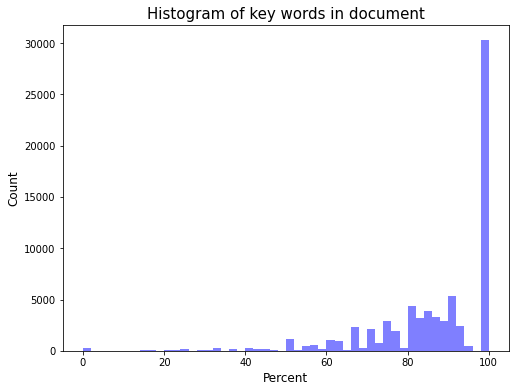

In [57]:
plt.figure(figsize=(8,6))

plt.title('Histogram of key words in document', fontsize=15)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Percent', fontsize=12)
plt.hist(text_vocab_count, color='blue', bins=50, alpha=0.5)

plt.show()